<a href="https://colab.research.google.com/github/slover1126/slover1126/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_3%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3.1 MNIST**


*   손으로 쓴 7만여개의 숫자 이미지 세트
*   분류기에서 자주 이용됨
*   sklearn.dataset은 크게 세가지 함수로 구성됨

    1.    **fetch_ X : 데이터셋 다운로드하는 함수**
    2.   **load_X : 소규모 데이터셋 다운로드하는 함수**
    3.   **make_X:테스트에 이용할 가짜 데이터셋을 만드는 함수**
* fetch_openml()의 경우 입력을 df,레이블을 series로 반환


In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) #as_frame 옵션:false 인경우 넘파이 array로 저장

In [2]:
X, y = mnist.data, mnist.target #mnist.data: 실제 데이터 값/mnist.target:데이터에 할당된 정답(레이블)
X
X.shape #(70000, 784) : 행이 7만개->전체 데이터셋의 개수 7만개/열이 784:하나의 이미지에 대해 28x28픽셀을 쭉 늘어트려 행벡터로 저장하여 다음과 같은 사이즈가 나옴
y.shape #(70000,) :실제 숫자 값이 담긴 열벡터

(70000,)

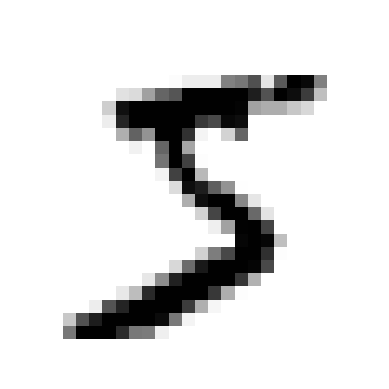

'5'

In [3]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28) #행벡터를 28x28 사이즈로 변환
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
y[0] # 5 로 출력됨

In [4]:
#훈련 세트와 테스트 세트 나누기
X_train,X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**3.2 이진 분류기 훈련**


*   숫자 5인지 여부를 확인하는 분류기



In [5]:
y_train_5 = (y_train =='5') #5는 true고 다른 숫자는 false인 벡터 생성(학습용 데이터)
print(y_train_5)
y_test_5 = (y_test == '5') #5는 true고 다른 숫자는 false인 벡터 생성(테스트용 데이터)
print(y_test_5)

#사이킷런의 SGDClassifier을 이용하기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #확률적 경사 하강법의 경우 데이터를 섞어서 학습을 진행하기 때문에 재현성을 위해 난수 고정
sgd_clf.fit(X_train, y_train_5) #학습

sgd_clf.predict([some_digit]) #0번 인덱스 값에 대한 예측치
#array([ True]) ->예측 잘 됨

[ True False False ...  True False False]
[False False False ... False  True False]


array([ True])

**3.3 성능 측정**

In [6]:
#3.3.1 교차검증을 사용한 정확도 측정(직접 구현해보기)
from sklearn.model_selection import StratifiedKFold #StratifiedKFold->층화 추출법을 k폴드 검증에 적용한 방식(5를 실제 비율에 맞게 샘플링해서 폴드에 할당)
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))
#0.95035,0.96035,0.9604

0.95035
0.96035
0.9604


In [7]:
#cross_val_score 이용
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") #cross_val_score(모델,X데이터,y데이터,몇개로 나눌지,측정 기준) 순으로 인자가 들어감
#array([0.95035, 0.96035, 0.9604 ])->모든 폴드에 대해 정확도가 95% 이상

array([0.95035, 0.96035, 0.9604 ])

In [8]:
#모든 이미지를 가장 많이 등장하는 클래스(5 아님)로 분류시켜보는 더미 분류기
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

#정확도 추정
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring = "accuracy")
#10%의 이미지만 5 이기 때문에 전부 5가 아니라고 해도 90%는 맞는 문제가 발생함

False


array([0.90965, 0.90965, 0.90965])



*   위 예시는 정확도를 분류기의 성능 지표로 사용하지 않는 이유를 보여줌(특히 불균형한 데이터셋인 경우)
*   대신 **오차 행렬(confusion matrix)**을 이용할 수 있음



**3.3.2 오차 행렬**


*   오차 행렬은 모든 A/B 쌍에 대해 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것임
* 예시로, 분류기가 숫자 8의 이미지를 0으로 잘못 분류한 횟수를 알고 싶다면 8번 행, 0번 열을 확인하면 됨



In [9]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#X_train 데이터에 대해 y_train_pred이라는 변수에 예측값을 저장하는 코드(3번 진행) ->2,3번으로 학습 후 1번 폴드에 대한 예측값 저장, 1,3번으로 학습후 2번 폴드에 대한 예측값 저장 ....
#실제 테스트 세트는 건드리지 않아야 하기 때문에 cross_val_predict 함수 이용
print(y_train_pred) #1차원 리스트 ->1~20000번은 1번 폴드를 예측시킨 결과/20001~40000번은 2번 폴드를 예측시킨 결과/40001~60000번은 3번 폴드를 예측시킨 결과를 하나의 리스트로 저장
y_train_pred.shape

[ True False False ...  True False False]


(60000,)

In [10]:
#confusion_matrix() 함수 이용
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred) #confusion_matrix(실제 훈련용 데이터의 값, 훈련 데이터의 예측값)
cm
#array([[53892,   687],
     #[ 1891,  3530]])
#행은 실제 클래스, 열은 예측한 클래스를 의미함
#첫 번쨰 행은 실제로 5 아님(0)을 의미하고, 두번째 행은 실제로 5임(1)을 의미함
#첫 번째 열은 5로 예측되지 않은 수를 의미하고, 두번째 열은 5로 예측되지 않은 수를 의미함

array([[53892,   687],
       [ 1891,  3530]])

###  오차 행렬 (Confusion Matrix)

| | **예측: Negative** | **예측: Positive ** |
| :--- | :---: | :---: |
| **실제: Negative ** | **TN** (True Negative) | **FP** (False Positive) |
| **실제: Positive ** | **FN** (False Negative) | **TP** (True Positive) |

*   정밀도(제대로 분류된 POSITIVE/전체 예측이 POSITIVE인 수)

$$Precision = \frac{TP}{TP + FP}$$



*   재현율(제대로 분류된 POSITIVE/실제 POSITIVE인 수)

$$Recall = \frac{TP}{TP + FN}$$

